In [1]:
import pandas as pd
import re
import time
from collections import Counter, defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from numpy import log, exp
from preprocessing import preprocess_dataframe, transform_colors
import numpy as np

### Manual pre-processing the data

In [2]:
cars_synth_train = pd.read_csv("data/synth/train.csv")
cars_synth_test = pd.read_csv("data/synth/test.csv")

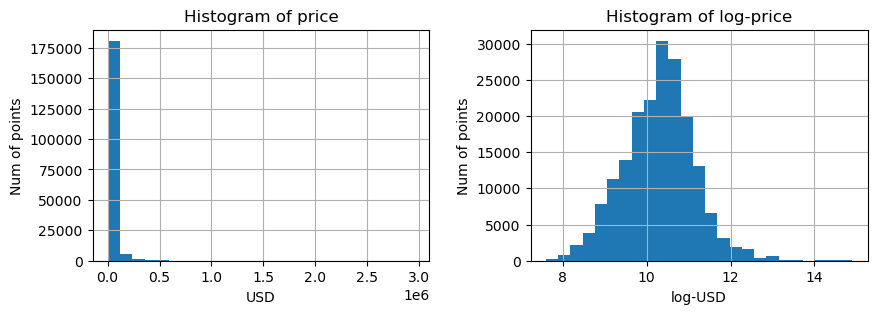

In [3]:
data = {'price': cars_synth_train["price"],
        'log-price': np.log(cars_synth_train["price"])}
df = pd.DataFrame(data)
hist = df.hist(bins=25, figsize=(10,3))
hist[0,0].set_title("Histogram of price")
hist[0,0].set_xlabel("USD")
hist[0,0].set_ylabel("Num of points")

hist[0,1].set_title("Histogram of log-price")
hist[0,1].set_xlabel("log-USD")
hist[0,1].set_ylabel("Num of points")

import matplotlib.pyplot as plt
plt.savefig('histograms.png')

In [3]:
cars_synth_pp_train = preprocess_dataframe(cars_synth_train)
cars_synth_pp_train["price"] = cars_synth_train["price"]
cars_synth_pp_test = preprocess_dataframe(cars_synth_test)
cars_synth_pp_train.to_csv("data/train_pp.csv")
cars_synth_pp_test.to_csv("data/test_pp.csv")

#### How to improve this step:
1. <s>Impute averages per model -> brand -> global (if missing)</s>
2. <s>Log-transform milage? Divide it by 1000?</s>
3. Include real data

### Defining sklearn pipeline

In [2]:
train_pp = pd.read_csv("data/train_pp.csv", index_col ="id")
test_pp = pd.read_csv("data/test_pp.csv", index_col ="id")
cat_vars = [c[0] for c in train_pp.dtypes.items() if c[1] == 'object']
bool_vars = [c[0] for c in train_pp.dtypes.items() if c[1] == 'bool']
num_vars = [c[0] for c in train_pp.dtypes.items() if c[1] in ['int64', 'float64'] if not c[0] == 'price']
y = train_pp["price"]
train_pp.drop("price", axis=1, inplace=True)
train_pp.shape

(188533, 33)

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

numeric_preprocessor = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(2))
    ]
)
categorical_preprocessor = Pipeline(
    steps=[
       ("onehot", OneHotEncoder(handle_unknown="ignore")),
       ("poly", PolynomialFeatures(2, interaction_only=True))
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_vars),
        ("numerical", numeric_preprocessor, num_vars),
        ("boolean", "passthrough", bool_vars)
    ],
    remainder='passthrough',
    
)

pipe = make_pipeline(preprocessor, LinearRegression(n_jobs=-1))
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['brand', 'fw_model',
                                                   'fuel_type',
                                                   'mapped_ext_color',
                                                   'mapped_int_color']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScal...
                                                   'speeds_transmission']),
                                                 ('boolean', 'passthrough',
                                                  ['gdi', 'mpfi', 'pdi', 'tfsi',
                                                   'dohc', 'sohc', 'turbo',
                                                   'ohv', 'straight', 'flat',
                                                   'electric', 'supercharged',
                                                   'at_transmission',
                                                   'manual_transmission',
                                                   'cvt_transmission',
                                                   'autoshift_transmission',
                                                   'dualshift_transmission',
                                                   'overdrive_transmission',
                                                   'accident_bool',
                                                   'clean_title_bool'])])),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_pp, y, test_size=0.2, random_state=42)

# Fit the pipeline to your training data
pipe.fit(X_train, y_train)

# Make predictions on the test set
y_hat = pipe.predict(X_test)
err = root_mean_squared_error(y_hat, y_test)
err

np.float64(69854.81294086072)

In [25]:
ridge_pipe = make_pipeline(preprocessor, linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0, 100, 500, 1000], cv=5, n_jobs=-1))
ridge_pipe.fit(X_train, y_train)
y_hat_ridge = ridge_pipe.predict(X_test)
err_ridge = root_mean_squared_error(y_hat_ridge, y_test)
err_ridge

np.float64(68132.27020287246)

In [30]:
y_hat = ridge_pipe.predict(test_pp)
submission = pd.DataFrame({"id": test_pp.index, "price": y_hat})
submission.to_csv("data/submissions/ridge_poly.csv", index=False)

In [26]:
elastic_pipe = make_pipeline(preprocessor, linear_model.ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], copy_X=False,
                                 random_state=42, n_jobs=-1, verbose=1, selection='random')
                            )
elastic_pipe.fit(X_train, y_train)
y_hat_elastic = elastic_pipe.predict(X_test)
err_elastic = root_mean_squared_error(y_hat_elastic, y_test)
err_elastic

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

np.float64(68168.86855524017)

In [31]:
y_hat = elastic_pipe.predict(test_pp)
submission = pd.DataFrame({"id": test_pp.index, "price": y_hat})
submission.to_csv("data/submissions/elasticNet_poly.csv", index=False)

In [9]:
lassolars_pipe = make_pipeline(preprocessor, linear_model.LassoCV(cv=5, verbose=1, max_iter=100, n_jobs=-1)
                            )
lassolars_pipe.fit(X_train, y_train)
y_hat_lassolars = lassolars_pipe.predict(X_test)
err_lassolars = root_mean_squared_error(y_hat_lassolars, y_test)
err_lassolars

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................C:\Users\chirk\.conda\envs\ml_base\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94512851529.625, tolerance: 74256424172.59308
  model = cd_fast.sparse_enet_coordinate_descent(
......C:\Users\chirk\.conda\envs\ml_base\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not con

np.float64(68168.87303202417)

In [11]:
y_hat = lassolars_pipe.predict(test_pp)
submission = pd.DataFrame({"id": test_pp.index, "price": y_hat})
submission.to_csv("data/submissions/lasso_poly.csv", index=False)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(n_splits=5)
scores = cross_val_score(pipe, X_train, y_train, cv = cv, scoring="neg_root_mean_squared_error")
scores

### Fitting an LGBM model onto original features

In [ ]:
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping


In [ ]:
for feature in cat_vars:          
    categories = sorted(list(set(train_pp[feature].dropna())))
    my_dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    
    train_pp[feature] = train_pp[feature].astype(my_dtype)
    test_pp[feature] = test_pp[feature].astype(my_dtype)

In [ ]:
lgbm_params = {
    'n_estimators': 800, #trial.suggest_int('n_estimators', 800, 1500),
    'num_leaves': 75, #trial.suggest_int('num_leaves', 75, 200),
    'max_depth': 12, #trial.suggest_int('max_depth', 12, 30),
    'cat_smooth': 20, #trial.suggest_int('cat_smooth', 20, 120),
    'learning_rate': 1e-3, #trial.suggest_loguniform('learning_rate', 1e-3, 0.02),
    'subsample': 0.5, #trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bytree': 0.4, #trial.suggest_uniform('colsample_bytree', 0.4, 0.8),
    'min_split_gain': 1e-4, #trial.suggest_loguniform('min_split_gain', 1e-4, 1.0),
    'min_child_weight': 5, #trial.suggest_int('min_child_weight', 5, 70),
    'lambda_l2': 1e-10, #trial.suggest_loguniform('lambda_l2', 1e-10, 1e-3),
    'lambda_l1': 1e-10, #trial.suggest_loguniform('lambda_l1', 1e-10, 1e-2),
    #'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 12.0),
    'max_bin': 200, #trial.suggest_int('max_bin', 200, 1000),
    }
    

# Fit the model
model_lgbm = lgb.LGBMRegressor(
    **lgbm_params, random_state=42, loss_function="RMSE", verbose=-1
)

In [ ]:
model_lgbm.fit(X_train, y_train)

In [ ]:
y_pred = model_lgbm.predict(X_test)
mean_squared_error(y_test, y_pred, squared = False)

## Further ideas

1. <s>Think about more meaningful handling of NAs</s>
2. <s>Explore color data</s>
3. <u>Check if the price needs log-transform - maybe, but it hasn't improved the score yet</u>
4. <s>Check if model data is meaningful</s> - I am taking only the first word of the model name -- adding only the first word still improved the score, so I'm keeping it this way.
5. <s>Explore further ML models</s>
6. Tune parameters of LGBM with optuna(??)
7. Try a neural network
8. Create ensemble of predictors
9. Include real data into the training set